In [2]:
import matplotlib.pyplot as plt
import os
import numpy as np

from core.environment.gridworlds import GridHardXY, GridHardRGB, GridTwoRoomRGB, GridOneRoomRGB

In [54]:
import numpy as np

from core.utils.torch_utils import random_seed


class GridHardXY:
    
    def __init__(self, seed=np.random.randint(int(1e5))):
        random_seed(seed)
        self.state_dim = (2,)
        self.max_x_dim = 15
        self.max_y_dim = 15
        self.action_dim = 4
        self.obstacles_map = self.get_obstacles_map()
        self.actions = [(0, 1), (0, -1), (1, 0), (-1, 0)] # right, left, down, up
        self.min_x, self.max_x, self.min_y, self.max_y = 0, self.max_x_dim-1, 0, self.max_y_dim-1
        self.goal_x, self.goal_y = 9, 9

        self.current_state = None

    def generate_state(self, coords):
        return np.array(coords)

    def info(self, key):
        return

    def reset(self):
        while True:
            rand_state = np.random.randint(low=0, high=max(self.max_x_dim, self.max_y_dim), size=2)
            rx, ry = rand_state
            if not int(self.obstacles_map[rx][ry]) and not (rx == self.goal_x and ry == self.goal_y):
                self.current_state = rand_state[0], rand_state[1]
                return self.generate_state(self.current_state)
    
    def step(self, a):
        dx, dy = self.actions[a[0]]
        x, y = self.current_state

        nx = x + dx
        ny = y + dy

        nx, ny = min(max(nx, self.min_x), self.max_x), min(max(ny, self.min_y), self.max_y)

        if not self.obstacles_map[nx][ny]:
            x, y = nx, ny

        self.current_state = x, y
        if x == self.goal_x and y == self.goal_y:
            return self.generate_state([x, y]), np.asarray(1.0), np.asarray(True), ""
        else:
            return self.generate_state([x, y]), np.asarray(0.0), np.asarray(False), ""

    def get_visualization_segment(self):
        state_coords = [[x, y] for x in range(self.max_x_dim)
                       for y in range(self.max_y_dim) if not int(self.obstacles_map[x][y])]
        states = [self.generate_state(coord) for coord in state_coords]
        goal_coords = [[9, 9], [0, 0], [14, 0], [7, 14]]
        goal_states = [self.generate_state(coord) for coord in goal_coords]
        return np.array(states), np.array(state_coords), np.array(goal_states), np.array(goal_coords)

    def get_obstacles_map(self):
        _map = np.zeros([self.max_x_dim, self.max_y_dim])
        _map[2, 0:6] = 1.0
        _map[2, 8:] = 1.0
        _map[3, 5] = 1.0
        _map[4, 5] = 1.0
        _map[5, 2:7] = 1.0
        _map[5, 9:] = 1.0
        _map[8, 2] = 1.0
        _map[8, 5] = 1.0
        _map[8, 8:] = 1.0
        _map[9, 2] = 1.0
        _map[9, 5] = 1.0
        _map[9, 8] = 1.0
        _map[10, 2] = 1.0
        _map[10, 5] = 1.0
        _map[10, 8] = 1.0
        _map[11, 2:6] = 1.0
        _map[11, 8:12] = 1.0
        _map[12, 5] = 1.0
        _map[13, 5] = 1.0
        _map[14, 5] = 1.0

        return _map

    def get_useful(self, state=None):
        if state:
            return state
        else:
            return self.current_state

class GridHardRGB(GridHardXY):
    def __init__(self, seed=np.random.randint(int(1e5))):
        super().__init__(seed)
    
        d = len(self.obstacles_map)
        self.state_dim = (d, d, 3)

        """
        # Gray-scale image
            Walls are Red
            Open spaces are Green
            Agent is Blue
        """
        self.rgb_template = np.zeros(self.state_dim)
        for x in range(d):
            for y in range(d):
                if self.obstacles_map[x][y]:
                    self.rgb_template[x][y][0] = 255.0
                else:
                    self.rgb_template[x][y][1] = 255.0

    def generate_state(self, coords):
        state = np.copy(self.rgb_template)
        x, y = coords
        assert state[x][y][1] == 255.0 and state[x][y][2] == 0.0

        state[x][y][1] = 0.0    # setting the green color on
        state[x][y][2] = 255.0  # turning the blue color on
        return state

    def get_features(self, state):
        raise NotImplementedError

    def get_useful(self, state=None):
        blue = np.array([0., 0., 255.])
        if state is None:
            state = self.generate_state(self.current_state)
        idx = np.where(np.all(state==blue, axis=2) == True)
        coord = np.array([idx[0][0], idx[1][0]])
        return coord

class GridHardTabular(GridHardRGB):
    def __init__(self, goal_state_idx, seed=np.random.randint(int(1e5))):
        super().__init__(seed)
        self.nos = (self.max_x_dim*self.max_y_dim)-int(np.sum(self.obstacles_map))
        self.state_idx_map = [(i, j) for i in range(self.max_x_dim)\
                              for j in range(self.max_y_dim) if not self.obstacles_map[i, j]]
        self.idx_state_map = np.zeros((self.max_x_dim, self.max_y_dim)).astype(np.int)
        
        for i in range(self.nos):
            x, y = self.state_idx_map[i]
            self.idx_state_map[x][y] = i
            
        self.goal_x, self.goal_y = self.state_idx_map[goal_state_idx]
        self.goal_state_idx = goal_state_idx
        
    def get_the_model(self):
        
        transition_matrix = np.zeros((self.nos, self.action_dim, self.nos))
        reward_model = np.zeros((self.nos, self.action_dim))
        
        for state_idx in range(self.nos):
            for a in range(self.action_dim):
                
                dx, dy = self.actions[a]
                x, y = self.state_idx_map[state_idx]

                nx = x + dx
                ny = y + dy

                nx, ny = min(max(nx, self.min_x), self.max_x), min(max(ny, self.min_y), self.max_y)

                if not self.obstacles_map[nx][ny]:
                    x, y = nx, ny
                
                next_state_idx = self.idx_state_map[x, y]
                transition_matrix[state_idx, a, next_state_idx] = 1.
                if (x, y) == (self.goal_x, self.goal_y):
                    if state_idx != self.goal_state_idx:
                        reward_model[state_idx, a] = 1.0
                    
        return transition_matrix, reward_model

    
class GridHardTabularRaw(GridHardTabular):
    """
    This is the environment with arbitrary number of rows and columns
    """
    def __init__(self, goal_state_idx, seed=np.random.randint(int(1e5)), max_x_dim=15, max_y_dim=15):
        super().__init__(goal_state_idx, seed)

        self.max_x_dim = max_x_dim
        self.max_y_dim = max_y_dim

        self.nos = (self.max_x_dim*self.max_y_dim)-int(np.sum(self.obstacles_map))
        self.state_idx_map = [(i, j) for i in range(self.max_x_dim)\
                              for j in range(self.max_y_dim) if not self.obstacles_map[i, j]]
        self.idx_state_map = np.zeros((self.max_x_dim, self.max_y_dim)).astype(np.int)
        
        for i in range(self.nos):
            x, y = self.state_idx_map[i]
            self.idx_state_map[x][y] = i
            
        self.goal_x, self.goal_y = self.state_idx_map[goal_state_idx]
        
        self.min_x, self.max_x, self.min_y, self.max_y = 0, self.max_x_dim-1, 0, self.max_y_dim-1
            
        
    def get_obstacles_map(self):
        _map = np.zeros([self.max_x_dim, self.max_y_dim])
        _map[1, 1] = 1.
        return _map
    
    
class GridHardTabularRawVI(GridHardTabularRaw):
    """
    This is the implementation where the transitions from goal states will results in any other state except the goal state arbitrary.
    """
    def __init__(self, goal_state_idx, seed=np.random.randint(int(1e5)),
                 max_x_dim=15, max_y_dim=15):
        super().__init__(goal_state_idx, seed, max_x_dim, max_y_dim)
  
    def get_the_model(self):
        
        transition_matrix = np.zeros((self.nos, self.action_dim, self.nos))
        reward_model = np.zeros((self.nos, self.action_dim))
        
        for state_idx in range(self.nos):
            for a in range(self.action_dim):
                
                dx, dy = self.actions[a]
                x, y = self.state_idx_map[state_idx]
                if (x, y) == (self.goal_x, self.goal_y):
                    transition_matrix[state_idx, a, :] = 1./(self.nos-1.)
                    transition_matrix[state_idx, a, state_idx] = 0.
                else:
                    nx = x + dx
                    ny = y + dy

                    nx, ny = min(max(nx, self.min_x), self.max_x), min(max(ny, self.min_y), self.max_y)

                    if not self.obstacles_map[nx][ny]:
                        x, y = nx, ny

                    next_state_idx = self.idx_state_map[x, y]
                    transition_matrix[state_idx, a, next_state_idx] = 1.
                    if (x, y) == (self.goal_x, self.goal_y):
                        if state_idx != self.goal_state_idx:
                            reward_model[state_idx, a] = 1.0
                            
        return transition_matrix, reward_model
                    
    def get_obstacles_map(self):
        _map = np.zeros([self.max_x_dim, self.max_y_dim])
        return _map

    

class GridHardTabularRawVII(GridHardTabularRaw):
    """
    This is the implementation where the transitions from goal states will results in the initial state.
    """
    def __init__(self, goal_state_idx, start_state_idx, seed=np.random.randint(int(1e5)),
                 max_x_dim=15, max_y_dim=15):
        super().__init__(goal_state_idx, seed, max_x_dim, max_y_dim)
        self.start_state_idx = start_state_idx
  
    def get_the_model(self):
        
        transition_matrix = np.zeros((self.nos, self.action_dim, self.nos))
        reward_model = np.zeros((self.nos, self.action_dim))
        
        for state_idx in range(self.nos):
            for a in range(self.action_dim):
                
                dx, dy = self.actions[a]
                x, y = self.state_idx_map[state_idx]
                if (x, y) == (self.goal_x, self.goal_y):
                    transition_matrix[state_idx, a, self.start_state_idx] = 1.
                    transition_matrix[state_idx, a, state_idx] = 0.
                else:
                    nx = x + dx
                    ny = y + dy

                    nx, ny = min(max(nx, self.min_x), self.max_x), min(max(ny, self.min_y), self.max_y)

                    if not self.obstacles_map[nx][ny]:
                        x, y = nx, ny

                    next_state_idx = self.idx_state_map[x, y]
                    transition_matrix[state_idx, a, next_state_idx] = 1.
                    if (x, y) == (self.goal_x, self.goal_y):
                        if state_idx != self.goal_state_idx:
                            reward_model[state_idx, a] = 1.0
        return transition_matrix, reward_model
                    
    def get_obstacles_map(self):
        _map = np.zeros([self.max_x_dim, self.max_y_dim])
        return _map
        

## Value Iteration

In [87]:


nos = 4
optimal_policies = []
max_x_dim = 2
max_y_dim = 2
start_state = 1
for goal_state in range(nos)[0:1]:
    env = GridHardTabularRawVI(goal_state, 0, max_x_dim, max_y_dim)
    env.reset()

    P, R = env.get_the_model()
    nos = env.nos  # no of states
    noa = env.action_dim
    print('The number of states: ', env.nos)
    
    delta = 0.00
    gamma = 0.99
    max_diff = 0
    
    V = np.zeros(nos)
    for time in range(0, 10):
        Vnew = np.zeros(nos)
        for i in range(nos):
            for a in range(noa):
                cur_val = 0
                for j in np.nonzero(P[i][a])[0]:
                    cur_val += P[i][a][j]*V[j]

                if goal_state == i:
                    cur_val *= 0.
                else:
                    cur_val *= gamma
                cur_val += R[i][a]

                Vnew[i] = max(Vnew[i], cur_val)
        max_diff = 0
        for i in range(nos):
            max_diff = max(max_diff, abs(V[i]-Vnew[i]))
            
        V = Vnew
        
        if(max_diff == delta):
            print('Goal {} Converged'.format(goal_state))
            break

    # one final iteration to determine the policy
    Vmax = np.zeros(nos)
    optimal_policy = np.zeros((nos, noa))
    optimal_actions = [[] for _ in range(nos)]
    for i in range(nos):
        for a in range(noa):
            cur_val = 0
            for j in range(nos):
                cur_val += P[i][a][j]*V[j]
            if goal_state == i:
                cur_val *= 0.
            else:
                cur_val *= gamma
            cur_val += R[i][a]
            if(Vmax[i] < cur_val):
                Vmax[i] = max(Vmax[i], cur_val)

        for a in range(noa):
            cur_val = 0
            for j in range(nos):
                cur_val += P[i][a][j]*V[j]
            if goal_state == i:
                cur_val *= 0
            else:
                cur_val *= gamma
            cur_val += R[i][a]
            if(Vmax[i] == cur_val):
                optimal_actions[i].append(a)
                
        for a in optimal_actions[i]:
            optimal_policy[i, a] = 1.
        optimal_policy[i, :] = optimal_policy[i, :]/np.sum(optimal_policy[i, :])
    optimal_policies.append(optimal_policy)

The number of states:  4
Goal 0 Converged


## Computing the policy models


In [88]:
delta = 0.00
gamma = 0.99
max_diff = 0

policy_models = []
for goal_state in range(nos)[0:1]:
    env = GridHardTabularRawVI(goal_state, 0, max_x_dim, max_y_dim)
    env.reset()

    nos = env.nos  # no of states
    policy_model = np.zeros((nos, nos))

#     print(nos)
    noa = env.action_dim
    P, R = env.get_the_model()
#     print(R.shape)
    for i in range(nos):
        for j in range(nos):
#             print('i, j: ', i, j)
            policy_model[i][j] = np.dot(P[i, :, j], optimal_policies[goal_state][i, :])
            
    policy_models.append(policy_model)

## Caculating the SR

In [86]:
np.linalg.inv(np.identity(4) - gamma * policy_models[0])[:, ]

array([[43.16484655, 21.29537704, 21.29537704, 14.24439936],
       [42.73319808, 22.08242327, 21.08242327, 14.10195537],
       [42.73319808, 21.08242327, 22.08242327, 14.10195537],
       [42.3058661 , 21.36659904, 21.36659904, 14.96093581]])

In [55]:
# np.random.seed(69)
# test_goals = []
# for c in np.random.choice(range(225), 30, replace=False):
#     test_goals.append((int(c//15), c%15))
# print(test_goals)
# state_idx_map = [(i, j) for i in range(14) for j in range(14) if not self.obstacles_map[i, j]]
# print(state_idx_map)


In [56]:
# env = GridHardTabularRaw(0, 0, 2, 1)
# env.nos

1

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


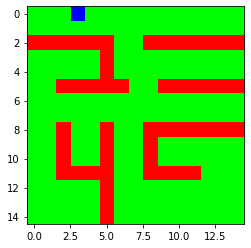

In [57]:
# env = GridHardTabular(0, 0)

# img = env.reset()

# plt.imshow(img)